In [1]:
import pandas as pd
import numpy as np
from mlp import *
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
def learn_with_val_vis(data, network, LOSS_target, metric,  lr, info_interval = 100, momentum_coef = 0.0, batch_size = None, max_epochs=10**10, regularization=0):
    X_train, Y_train, X_test, Y_test = data
    k = 1/100000
    ef_lr = lr
    max_x = max(X_train)
    min_x = min(X_train)
    max_y = max(Y_train)
    min_y = min(Y_train)

    avgx = (max_x + min_x) / 2
    avgy = (max_y + min_y) / 2

    x_scl = (max_x - min_x) / 2
    y_scl = (max_y - min_y) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    Y_tr_scl = (Y_train - avgy) / y_scl
    X_ts_scl = (X_test - avgx) / x_scl
    Y_ts_scl = (Y_test - avgy) / y_scl

    epoch = 0
    pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
    LOSS = np.mean((Y_test - pred)**2)
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}")
        pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
        LOSS = np.mean((Y_test - pred)**2)
        if LOSS < LOSS_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}")
            break
        network.epoch(X_tr_scl.reshape(-1,1), Y_tr_scl.reshape(-1,1), metric, ef_lr, momentum_coef, batch_size, regularization)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    plt.plot(X_test, Y_test, 'o', label='Original Data')
    plt.plot(X_test, pred.reshape(-1), 'o', color='red', label='Predicted Data')
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"LOSS: {LOSS}")
    plt.legend()

In [3]:
def learn_with_val_vis_stop(data, network, LOSS_target, metric,  lr, info_interval = 100, momentum_coef = 0.0, batch_size = None, max_epochs=10**10, regularization=0):
    X_train, Y_train, X_test, Y_test = data
    k = 1/100000
    ef_lr = lr
    max_x = max(X_train)
    min_x = min(X_train)
    max_y = max(Y_train)
    min_y = min(Y_train)

    avgx = (max_x + min_x) / 2
    avgy = (max_y + min_y) / 2

    x_scl = (max_x - min_x) / 2
    y_scl = (max_y - min_y) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    Y_tr_scl = (Y_train - avgy) / y_scl
    X_ts_scl = (X_test - avgx) / x_scl
    Y_ts_scl = (Y_test - avgy) / y_scl


    epoch = 0
    pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
    LOSS = np.mean((Y_test - pred)**2)
    min_LOSS = LOSS
    ema_LOSS = LOSS
    min_weigts = network.weights
    min_biases = network.biases
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, ema_LOSS: {ema_LOSS}")
        pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
        LOSS = np.mean((Y_test - pred)**2)
        if LOSS < min_LOSS:
            min_LOSS = LOSS
            min_weigts = network.weights
            min_biases = network.biases
        if LOSS > 1.1*ema_LOSS:
            network.weights = min_weigts
            network.biases = min_biases
            pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
            break
        ema_LOSS = 0.99*ema_LOSS + 0.01*LOSS
        if LOSS < LOSS_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}")
            break
        network.epoch(X_tr_scl.reshape(-1,1), Y_tr_scl.reshape(-1,1), metric, ef_lr, momentum_coef, batch_size, regularization)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    plt.plot(X_test, Y_test, 'o', label='Original Data')
    plt.plot(X_test, pred.reshape(-1), 'o', color='red', label='Predicted Data')
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"LOSS: {LOSS}")
    plt.legend()

In [4]:
def cross_entropy_loss(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Avoid log(0)
    return -np.sum(y_true * np.log(y_pred))

def one_hot_encode_last_column(df):
    column = df.columns[-1]  # Get the last column name
    one_hot = pd.get_dummies(df[column], prefix=column, dtype=int)  # One-hot encode
    df = df.drop(columns=[column])  # Drop original column
    return pd.concat([df, one_hot], axis=1)

In [5]:
def visualise_real_vs_predict(X_test, original_cat_test, pred):
    plt.figure()
    scatter_or = plt.scatter(X_test[:,0], X_test[:,1], c=pd.Categorical(original_cat_test).codes, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Categories')
    categories = pd.Categorical(original_cat_test).categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_or.cmap(scatter_or.norm(i)), markersize=10) for i in range(len(categories))]
    plt.legend(handles, categories, title='Categories')

    plt.figure()
    scatter_pr = plt.scatter(X_test[:,0], X_test[:,1], c=pd.Categorical(pred).codes, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Predicted Categories')
    categories = pd.Categorical(pred).categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_pr.cmap(scatter_pr.norm(i)), markersize=10) for i in range(len(categories))]
    plt.legend(handles, categories, title='Predicted Categories')
    plt.show()

In [6]:
def learn_with_val_vis_cat_stop(data, network, f_measure_target, metric, lr, info_interval = 100, momentum_coef = 0.0, batch_size = None, max_epochs=10**10, regularization=0):
    X_train, Y_train, X_test, Y_test = data
    k = 1/1000
    ef_lr = lr
    max_x = np.max(X_train, axis=0)
    min_x = np.min(X_train, axis=0)
    original_cat_test = np.argmax(Y_test, axis=1)

    avgx = (max_x + min_x) / 2


    x_scl = (max_x - min_x) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    X_ts_scl = (X_test - avgx) / x_scl

    epoch = 0
    pred = network.predict_multiple(X_ts_scl)
    LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
    min_LOSS = LOSS
    ema_LOSS = LOSS
    min_weigts = network.weights
    min_biases = network.biases
    pred = np.argmax(pred, axis=1)
    f_measure = f1_score(original_cat_test, pred, average = 'macro')
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, ema_LOSS: {ema_LOSS} f-measure: {f_measure}")
        pred = network.predict_multiple(X_ts_scl)
        LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
        if LOSS < min_LOSS:
            min_LOSS = LOSS
            min_weigts = network.weights
            min_biases = network.biases
        if LOSS > 1.1*ema_LOSS:
            network.weights = min_weigts
            network.biases = min_biases
            pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + avgy
            pred = np.argmax(pred, axis=1)
            break
        pred = np.argmax(pred, axis=1)
        f_measure = f1_score(original_cat_test, pred, average='macro')
        ema_LOSS = 0.99*ema_LOSS + 0.01*LOSS
        if f_measure >= f_measure_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
            break
        network.epoch(X_tr_scl, Y_train, metric, ef_lr, momentum_coef, batch_size, regularization)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    visualise_real_vs_predict(X_test, original_cat_test, pred)

In [7]:
def learn_with_val_vis_cat(data, network, f_measure_target, metric, lr, info_interval = 100, momentum_coef = 0.0, batch_size = None, max_epochs=10**10, regularization=0):
    X_train, Y_train, X_test, Y_test = data
    k = 1/1000
    ef_lr = lr
    max_x = np.max(X_train, axis=0)
    min_x = np.min(X_train, axis=0)
    original_cat_test = np.argmax(Y_test, axis=1)

    avgx = (max_x + min_x) / 2


    x_scl = (max_x - min_x) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    X_ts_scl = (X_test - avgx) / x_scl

    epoch = 0
    pred = network.predict_multiple(X_ts_scl)
    LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
    pred = np.argmax(pred, axis=1)
    f_measure = f1_score(original_cat_test, pred, average = 'macro')
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
        pred = network.predict_multiple(X_ts_scl)
        LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
        pred = np.argmax(pred, axis=1)
        f_measure = f1_score(original_cat_test, pred, average='macro')
        if f_measure >= f_measure_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
            break
        network.epoch(X_tr_scl, Y_train, metric, ef_lr, momentum_coef, batch_size, regularization)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    visualise_real_vs_predict(X_test, original_cat_test, pred)

In [8]:
train = pd.read_csv("../data/regression/multimodal-sparse-training.csv")
test = pd.read_csv("../data/regression/multimodal-sparse-test.csv")

X_train = train['x'].values
Y_train = train['y'].values
X_test = test['x'].values
Y_test = test['y'].values

data = (X_train, Y_train, X_test, Y_test)

max_x = max(X_train)
min_x = min(X_train)
max_y = max(Y_train)
min_y = min(Y_train)

avgx = (max_x + min_x) / 2
avgy = (max_y + min_y) / 2

x_scl = (max_x - min_x) / 2
y_scl = (max_y - min_y) / 2
X_tr_scl = (X_train - avgx) / x_scl
Y_tr_scl = (Y_train - avgy) / y_scl
X_ts_scl = (X_test - avgx) / x_scl
Y_ts_scl = (Y_test - avgy) / y_scl

# 1.1 MMS BASE

Weights, epoch: 0, LOSS: 83048.41903717518
Weights, epoch: 500, LOSS: 547.8140973763765
Weights, epoch: 1000, LOSS: 445.01997655933155
Weights, epoch: 1500, LOSS: 363.45047516882846
Weights, epoch: 2000, LOSS: 289.9424690620984
Weights, epoch: 2500, LOSS: 280.47424808364764
Weights, epoch: 3000, LOSS: 241.929197760078
Weights, epoch: 3500, LOSS: 238.07749182146756
Weights, epoch: 4000, LOSS: 216.55746527678897
Weights, epoch: 4500, LOSS: 221.58931435771868
Weights, epoch: 5000, LOSS: 199.97768487522836
Weights, epoch: 5500, LOSS: 198.68118684358723
Weights, epoch: 6000, LOSS: 200.6784684381012
Weights, epoch: 6500, LOSS: 180.8008008733888
Weights, epoch: 7000, LOSS: 186.26315664114387
Weights, epoch: 7500, LOSS: 179.7159907057181
Weights, epoch: 8000, LOSS: 181.61288127850995
Weights, epoch: 8500, LOSS: 170.62699897656177
Weights, epoch: 9000, LOSS: 171.0634153198432
Weights, epoch: 9500, LOSS: 172.34081813913343
Weights, epoch: 10000, LOSS: 160.0825191656005
Weights, epoch: 10001, LOS

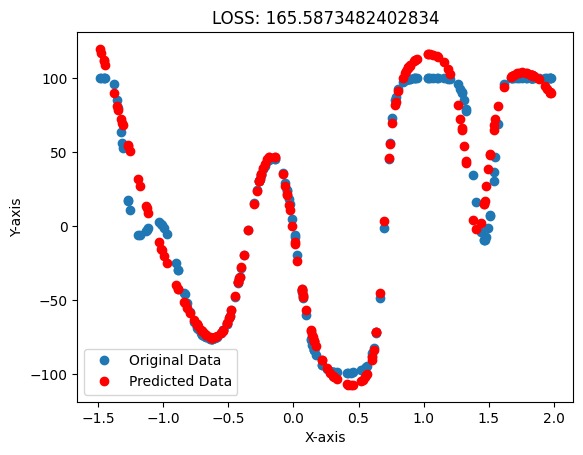

In [52]:
network = MLP([1,10,10,10,1], ["arctan", "arctan", "arctan", "identity"])
learn_with_val_vis(data, network, 1, "MSE", 0.01, 500, 0.0, 3, 10000, 0)

# 1.2 MMS L<sup>1</sup>

Weights, epoch: 0, LOSS: 305998.5568197212
Weights, epoch: 500, LOSS: 448.5758210134179
Weights, epoch: 1000, LOSS: 308.0706004460399
Weights, epoch: 1500, LOSS: 300.8062861163415
Weights, epoch: 2000, LOSS: 232.39929325177008
Weights, epoch: 2500, LOSS: 217.23310706067917
Weights, epoch: 3000, LOSS: 221.18221970073725
Weights, epoch: 3500, LOSS: 212.2110220800244
Weights, epoch: 4000, LOSS: 187.19593634739104
Weights, epoch: 4500, LOSS: 180.28441676240502
Weights, epoch: 5000, LOSS: 170.84690317939217
Weights, epoch: 5500, LOSS: 148.99112335420733
Weights, epoch: 6000, LOSS: 170.31624162743717
Weights, epoch: 6500, LOSS: 147.8022652493315
Weights, epoch: 7000, LOSS: 136.90182572307236
Weights, epoch: 7500, LOSS: 147.1200913567396
Weights, epoch: 8000, LOSS: 161.30722239537164
Weights, epoch: 8500, LOSS: 165.40937762486922
Weights, epoch: 9000, LOSS: 139.85540590272478
Weights, epoch: 9500, LOSS: 168.57083542439207
Weights, epoch: 10000, LOSS: 137.52855662413833
Weights, epoch: 10001, 

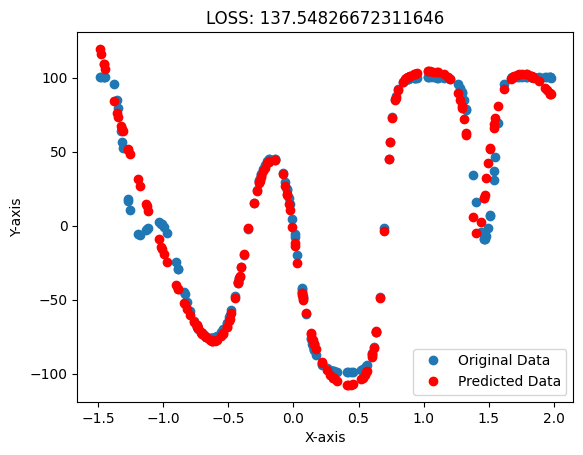

In [54]:
network = MLP([1,10,10,10,1], ["arctan", "arctan", "arctan", "identity"])
learn_with_val_vis(data, network, 1, "MSE", 0.01, 500, 0.0, 3, 10000, 1)

# 1.3 MMS L<sup>2

Weights, epoch: 0, LOSS: 69561.97367070742
Weights, epoch: 500, LOSS: 549.996569947662
Weights, epoch: 1000, LOSS: 471.682162876695
Weights, epoch: 1500, LOSS: 479.1826920154337
Weights, epoch: 2000, LOSS: 476.603273282579
Weights, epoch: 2500, LOSS: 470.67484452855615
Weights, epoch: 3000, LOSS: 464.5007627100192
Weights, epoch: 3500, LOSS: 455.8404041285618
Weights, epoch: 4000, LOSS: 428.6965847688174
Weights, epoch: 4500, LOSS: 496.3105888198559
Weights, epoch: 5000, LOSS: 429.4835701520517
Weights, epoch: 5500, LOSS: 480.49637142182735
Weights, epoch: 6000, LOSS: 427.96452511213005
Weights, epoch: 6500, LOSS: 468.003708549379
Weights, epoch: 7000, LOSS: 426.78491899965707
Weights, epoch: 7500, LOSS: 459.169443712106
Weights, epoch: 8000, LOSS: 412.01627612805476
Weights, epoch: 8500, LOSS: 416.9136641881734
Weights, epoch: 9000, LOSS: 393.8772388843466
Weights, epoch: 9500, LOSS: 391.7821046866196
Weights, epoch: 10000, LOSS: 401.2060303125382
Weights, epoch: 10001, LOSS: 413.3680

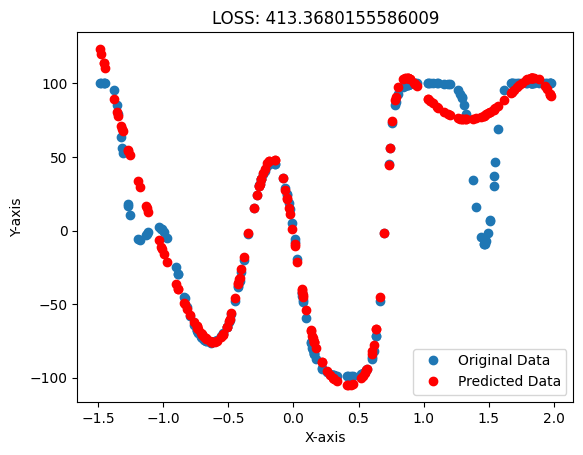

In [55]:
network = MLP([1,10,10,10,1], ["arctan", "arctan", "arctan", "identity"])
learn_with_val_vis(data, network, 1, "MSE", 0.01, 500, 0.0, 3, 10000, 2)

# 1.4 MMS Early Stopping

Weights, epoch: 0, LOSS: 339632.0996276263, ema_LOSS: 339632.0996276263
Weights, epoch: 500, LOSS: 673.9814096775739, ema_LOSS: 3399.103933651654
Weights, epoch: 1000, LOSS: 414.40740757738126, ema_LOSS: 421.5661192227646


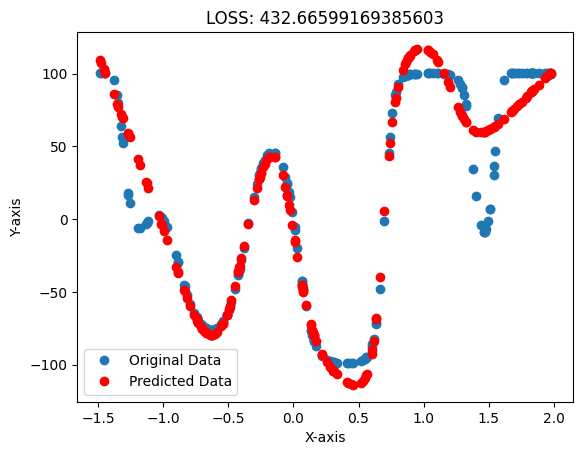

In [56]:
network = MLP([1,10,10,10,1], ["arctan", "arctan", "arctan", "identity"])
learn_with_val_vis_stop(data, network, 1, "MSE", 0.01, 500, 0.0, 3, 10000, 0)

# 2.1 Rings5 BASE

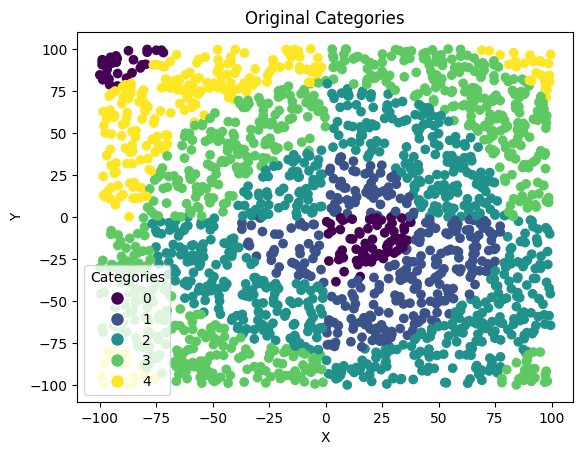

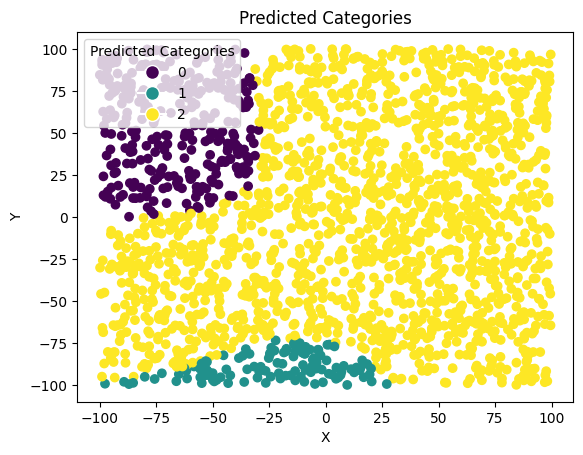

In [9]:
network = MLP([2, 10, 10, 10, 5], ["arctan", "arctan", "arctan", "softmax"])
train = pd.read_csv("../data/classification/rings5-sparse-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("../data/classification/rings5-sparse-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)

X_train = train[['x', 'y']].values
Y_train = train.drop(columns=['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns=['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)

avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 6701.684578476311, f-measure: 0.10303561795847911
Weights, epoch: 25, LOSS: 2588.5602231091225, f-measure: 0.4785497523521755
Weights, epoch: 50, LOSS: 2334.552030976849, f-measure: 0.5312626659730924
Weights, epoch: 75, LOSS: 2137.4237980330486, f-measure: 0.5788909562720698
Weights, epoch: 100, LOSS: 1970.8172358679421, f-measure: 0.5965979130903941
Weights, epoch: 125, LOSS: 1809.1557444580744, f-measure: 0.6237655421832475
Weights, epoch: 150, LOSS: 1747.4897167578008, f-measure: 0.6508621203013715
Weights, epoch: 175, LOSS: 1663.6055211120174, f-measure: 0.6762117189727543
Weights, epoch: 200, LOSS: 1599.2940480963925, f-measure: 0.677769423730388
Weights, epoch: 225, LOSS: 1557.5934256116307, f-measure: 0.6682163629633349
Weights, epoch: 250, LOSS: 1526.271967493621, f-measure: 0.6591144643245463
Weights, epoch: 275, LOSS: 1491.635570493563, f-measure: 0.6680347376864428
Weights, epoch: 300, LOSS: 1433.0378206270987, f-measure: 0.688438989698306
Weights, 

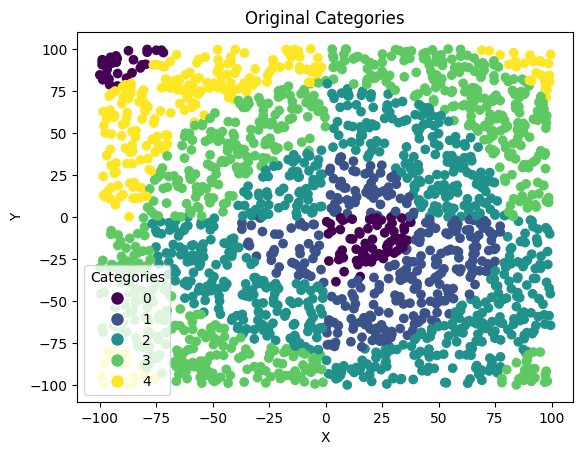

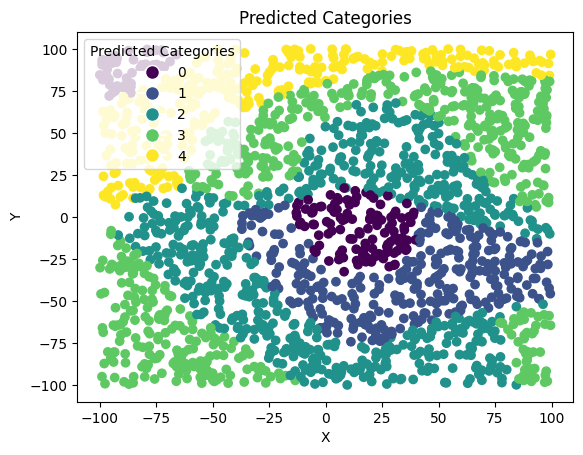

In [73]:
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

Weights, epoch: 0, LOSS: 10674.93821125452, f-measure: 0.12160473601834602
Weights, epoch: 25, LOSS: 2714.491339868045, f-measure: 0.38943265776083935
Weights, epoch: 50, LOSS: 2239.6278779757986, f-measure: 0.4438726065597242
Weights, epoch: 75, LOSS: 2030.563648368799, f-measure: 0.5874252458249907
Weights, epoch: 100, LOSS: 1836.357148346622, f-measure: 0.6336070745264615
Weights, epoch: 125, LOSS: 1705.6025295166328, f-measure: 0.6629860756152507
Weights, epoch: 150, LOSS: 1587.7377741763446, f-measure: 0.6814466051465115
Weights, epoch: 175, LOSS: 1454.0869583537415, f-measure: 0.7169743662805705
Weights, epoch: 200, LOSS: 1416.290393289861, f-measure: 0.7140735023751956
Weights, epoch: 225, LOSS: 1354.6647783008816, f-measure: 0.7209965696734643
Weights, epoch: 250, LOSS: 1340.0337944272412, f-measure: 0.723175705571001
Weights, epoch: 275, LOSS: 1334.1592894843673, f-measure: 0.7172938335924685
Weights, epoch: 300, LOSS: 1294.9748429030046, f-measure: 0.7405003081786918
Weights,

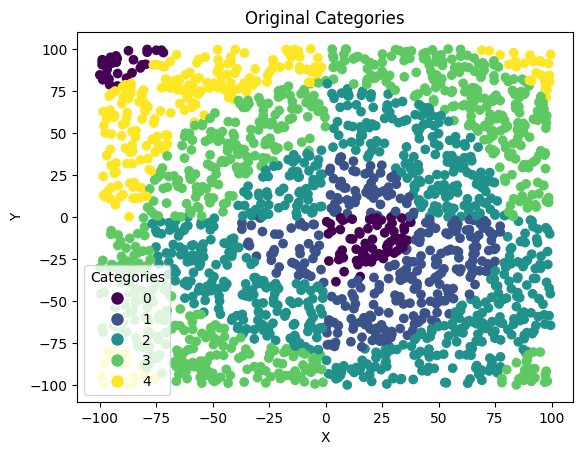

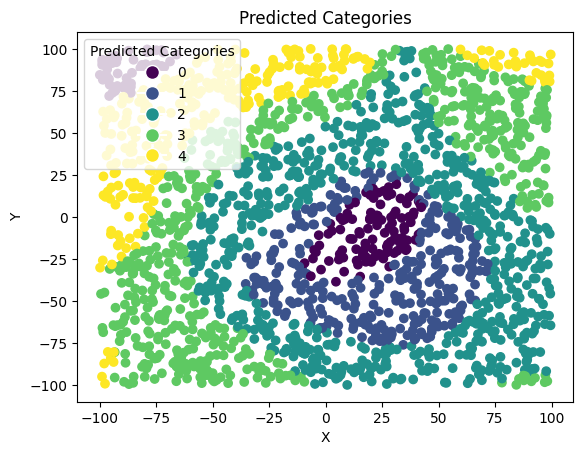

In [66]:
network = MLP([2, 10, 10, 10, 5], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 1)

Weights, epoch: 0, LOSS: 7872.133981484284, f-measure: 0.10203193233613321
Weights, epoch: 25, LOSS: 2878.090188785311, f-measure: 0.39906210945856585
Weights, epoch: 50, LOSS: 2373.0412662242265, f-measure: 0.5012549153347746
Weights, epoch: 75, LOSS: 2125.485736909913, f-measure: 0.5634601582062085
Weights, epoch: 100, LOSS: 1990.8813481775226, f-measure: 0.5934203799006867
Weights, epoch: 125, LOSS: 1866.5191104262904, f-measure: 0.6123607464388582
Weights, epoch: 150, LOSS: 1768.1078929331566, f-measure: 0.6277666890189957
Weights, epoch: 175, LOSS: 1669.6216317828296, f-measure: 0.6688854988967645
Weights, epoch: 200, LOSS: 1671.538549574063, f-measure: 0.6715564157762351
Weights, epoch: 225, LOSS: 1557.6637666408542, f-measure: 0.6915731050415334
Weights, epoch: 250, LOSS: 1540.3162507324164, f-measure: 0.6826973422049344
Weights, epoch: 275, LOSS: 1466.1209214185865, f-measure: 0.7153508582654051
Weights, epoch: 300, LOSS: 1443.8061245240779, f-measure: 0.7192244543850499
Weight

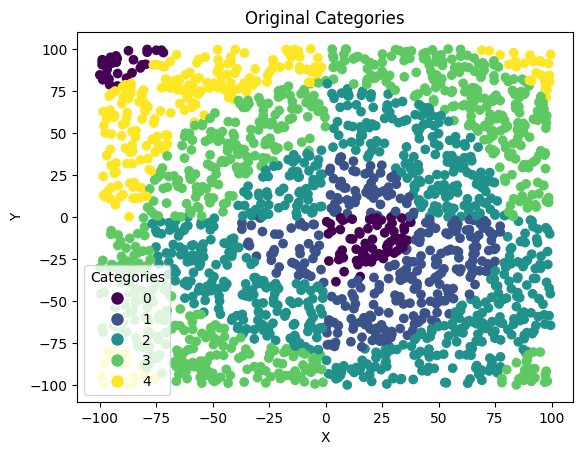

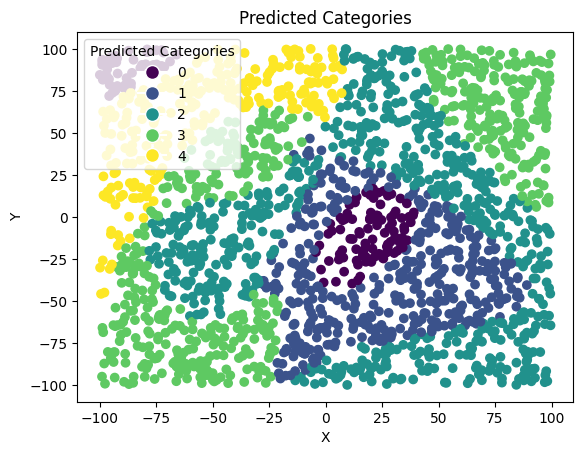

In [67]:
network = MLP([2, 10, 10, 10, 5], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 2)

Weights, epoch: 0, LOSS: 6823.981900215107, ema_LOSS: 6823.981900215107 f-measure: 0.07914092870976311
Weights, epoch: 25, LOSS: 2878.378444265365, ema_LOSS: 6061.29099695414 f-measure: 0.3869048487197994
Weights, epoch: 50, LOSS: 2650.7090218444623, ema_LOSS: 5323.02803283012 f-measure: 0.37410417949668623
Weights, epoch: 75, LOSS: 2497.718445797695, ema_LOSS: 4704.954031562132 f-measure: 0.3909431825740662
Weights, epoch: 100, LOSS: 2449.3294821100308, ema_LOSS: 4201.864046221501 f-measure: 0.47713412963683705
Weights, epoch: 125, LOSS: 2302.7447148559777, ema_LOSS: 3790.417570138926 f-measure: 0.5181872291942765
Weights, epoch: 150, LOSS: 2302.3472610264466, ema_LOSS: 3458.1448832971496 f-measure: 0.512467762926517
Weights, epoch: 175, LOSS: 2174.0392508654754, ema_LOSS: 3190.586251989967 f-measure: 0.5386408302139807
Weights, epoch: 200, LOSS: 2185.644925387861, ema_LOSS: 2969.1469026887353 f-measure: 0.5372865689354207
Weights, epoch: 225, LOSS: 2140.9000292663186, ema_LOSS: 2792.

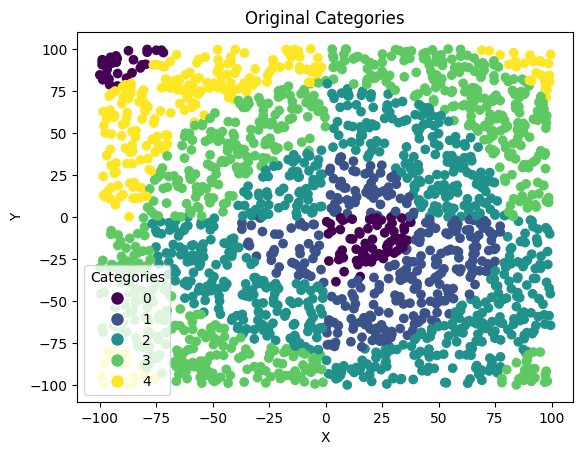

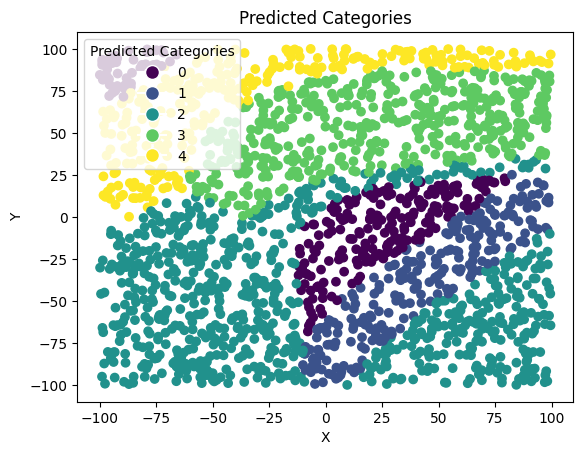

In [78]:
network = MLP([2, 10, 10, 10, 5], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat_stop(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

# 3.2 rings3 BASE

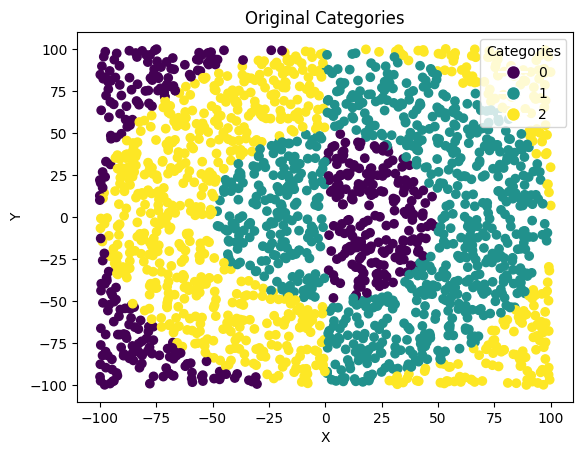

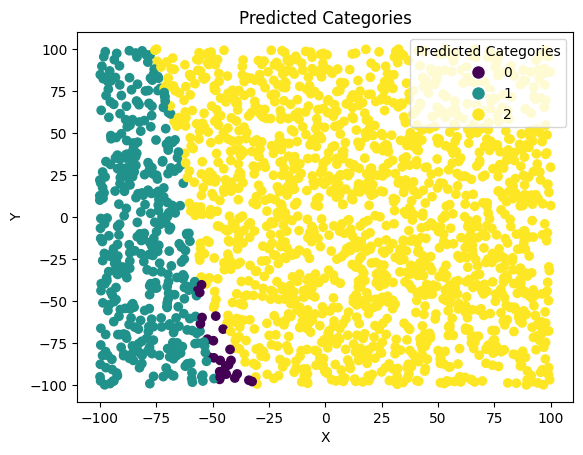

In [81]:
network = MLP([2, 10, 10, 10, 3], ["arctan", "arctan", "arctan", "softmax"])
train = pd.read_csv("../data/classification/rings3-balance-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("../data/classification/rings3-balance-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)

X_train = train[['x', 'y']].values
Y_train = train.drop(columns=['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns=['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)

avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 4358.844254848676, f-measure: 0.16330266572304789
Weights, epoch: 25, LOSS: 2863.328377471661, f-measure: 0.42664281045360086
Weights, epoch: 50, LOSS: 2244.8033291333913, f-measure: 0.4727339257153958
Weights, epoch: 75, LOSS: 1934.8391918154744, f-measure: 0.5454971410879511
Weights, epoch: 100, LOSS: 1785.4072950706395, f-measure: 0.6190560882198936
Weights, epoch: 125, LOSS: 1694.2197535718262, f-measure: 0.6538385024207559
Weights, epoch: 150, LOSS: 1480.5002750020403, f-measure: 0.7137162828374338
Weights, epoch: 175, LOSS: 1433.101333105887, f-measure: 0.7361193084371088
Weights, epoch: 200, LOSS: 1330.1465619437404, f-measure: 0.7596022716647853
Weights, epoch: 225, LOSS: 1226.0442252744228, f-measure: 0.7904882079134246
Weights, epoch: 250, LOSS: 1166.3986001147127, f-measure: 0.7974910316748973
Weights, epoch: 275, LOSS: 1109.693750096835, f-measure: 0.8095143344208685
Weights, epoch: 300, LOSS: 1057.1570309181375, f-measure: 0.8106615260332651
Weight

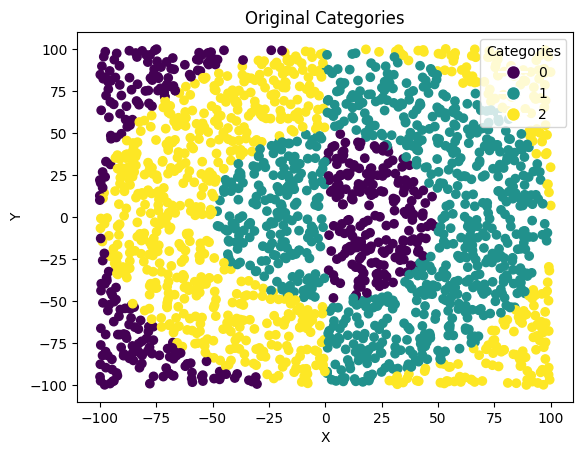

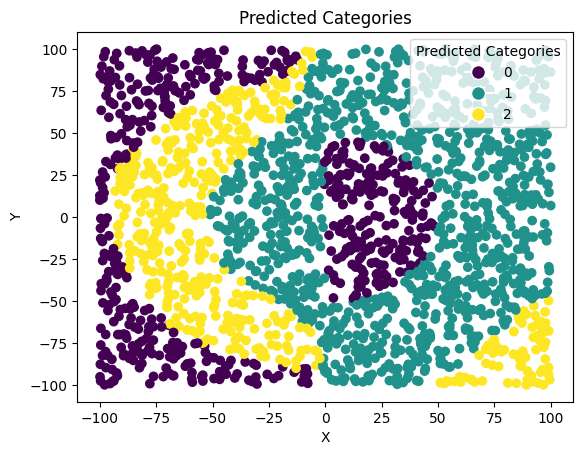

In [82]:
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

# 3.2 rings3 L<sup>1

Weights, epoch: 0, LOSS: 4199.517116235181, f-measure: 0.3621191558322468
Weights, epoch: 25, LOSS: 2195.8204162927486, f-measure: 0.517011943060798
Weights, epoch: 50, LOSS: 1750.4532976747678, f-measure: 0.6574207330365699
Weights, epoch: 75, LOSS: 1612.5858981470724, f-measure: 0.6890607034070749
Weights, epoch: 100, LOSS: 1475.4164864844995, f-measure: 0.7174716479494903
Weights, epoch: 125, LOSS: 1311.1675874690409, f-measure: 0.7626866902549212
Weights, epoch: 150, LOSS: 1280.9123076066835, f-measure: 0.757071008106878
Weights, epoch: 175, LOSS: 1064.6213225015667, f-measure: 0.7973714703678123
Weights, epoch: 200, LOSS: 1053.6472495110775, f-measure: 0.7962269650666984
Weights, epoch: 225, LOSS: 1104.6369193269416, f-measure: 0.8122280264746916
Weights, epoch: 250, LOSS: 1023.5311926724589, f-measure: 0.807582957291363
Weights, epoch: 275, LOSS: 994.7177198058283, f-measure: 0.8107949717786472
Weights, epoch: 300, LOSS: 970.7041097042727, f-measure: 0.8187520266269138
Weights, e

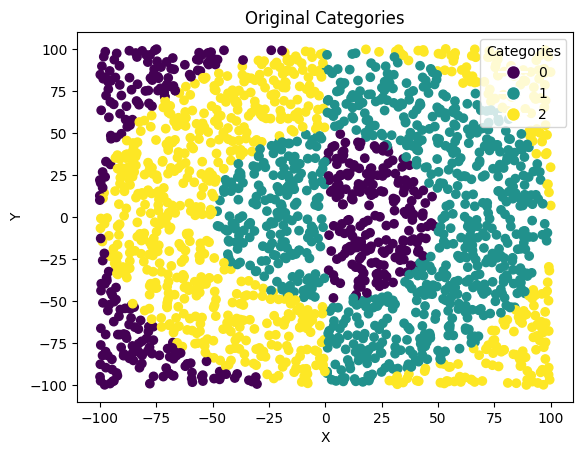

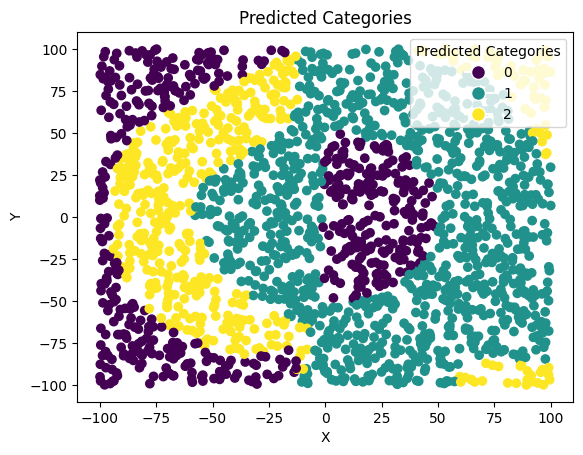

In [83]:
network = MLP([2, 10, 10, 10, 3], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 1)

# 3.3 rings3 L<sup>2

Weights, epoch: 0, LOSS: 5174.142605698073, f-measure: 0.24004771400085456
Weights, epoch: 25, LOSS: 2201.3403980533003, f-measure: 0.5270528058387277
Weights, epoch: 50, LOSS: 1644.9836482281885, f-measure: 0.6311417239277998
Weights, epoch: 75, LOSS: 1479.560068791805, f-measure: 0.6605914460050079
Weights, epoch: 100, LOSS: 1326.8905517620942, f-measure: 0.691837530698335
Weights, epoch: 125, LOSS: 1286.9018456146534, f-measure: 0.6994947007945985
Weights, epoch: 150, LOSS: 1175.2444462186845, f-measure: 0.7266947229883766
Weights, epoch: 175, LOSS: 1169.6647752619415, f-measure: 0.7330662349953357
Weights, epoch: 200, LOSS: 1039.2970830847573, f-measure: 0.7767165696276978
Weights, epoch: 225, LOSS: 1096.5666549896748, f-measure: 0.7540582075396922
Weights, epoch: 250, LOSS: 981.6216839334173, f-measure: 0.7812387970758188
Weights, epoch: 275, LOSS: 1079.255983252012, f-measure: 0.754668970381665
Weights, epoch: 300, LOSS: 1015.8107483853589, f-measure: 0.7682155486572405
Weights, 

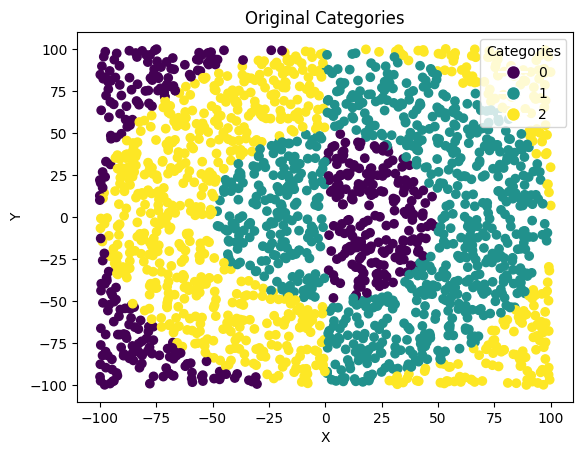

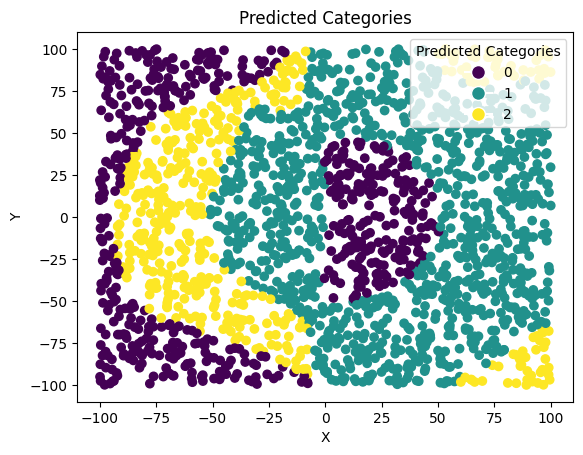

In [84]:
network = MLP([2, 10, 10, 10, 3], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 2)

# 3.4 rings3 Early Stopping

Weights, epoch: 0, LOSS: 8434.772979205296, ema_LOSS: 8434.772979205296 f-measure: 0.12004106520206094
Weights, epoch: 25, LOSS: 2383.4106171749045, ema_LOSS: 7240.19434186707 f-measure: 0.4845449237579264
Weights, epoch: 50, LOSS: 2083.7092635871027, ema_LOSS: 6125.643467108388 f-measure: 0.49150446836095707
Weights, epoch: 75, LOSS: 1919.1629657457854, ema_LOSS: 5209.754505127039 f-measure: 0.49158411926933837
Weights, epoch: 100, LOSS: 1803.2289760075419, ema_LOSS: 4469.923280460551 f-measure: 0.50112119608095
Weights, epoch: 125, LOSS: 1752.1223174789623, ema_LOSS: 3874.0195110481586 f-measure: 0.5250624621924654
Weights, epoch: 150, LOSS: 1672.0036750375461, ema_LOSS: 3394.0760094347347 f-measure: 0.5482394907515017
Weights, epoch: 175, LOSS: 1615.104688273875, ema_LOSS: 3003.798602338438 f-measure: 0.5632443528048787
Weights, epoch: 200, LOSS: 1545.7395836644046, ema_LOSS: 2689.3219622665747 f-measure: 0.5734853732017512
Weights, epoch: 225, LOSS: 1491.928927136326, ema_LOSS: 243

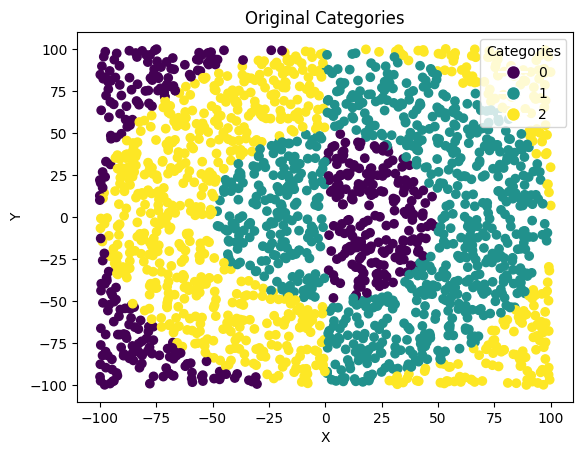

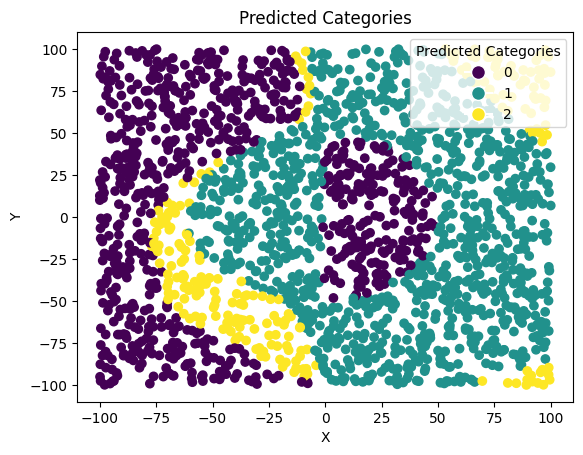

In [85]:
network = MLP([2, 10, 10, 10, 3], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat_stop(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

# 4.1 XOR BASE

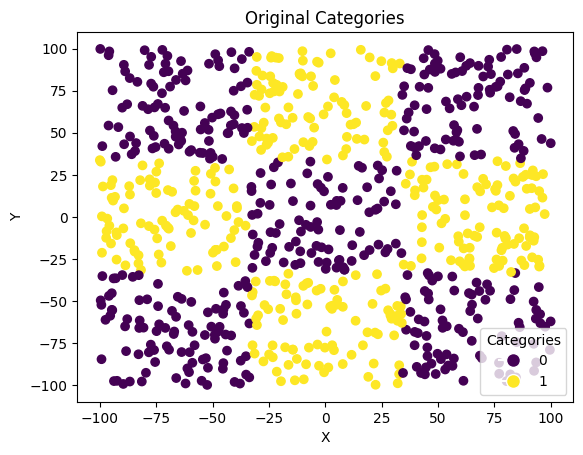

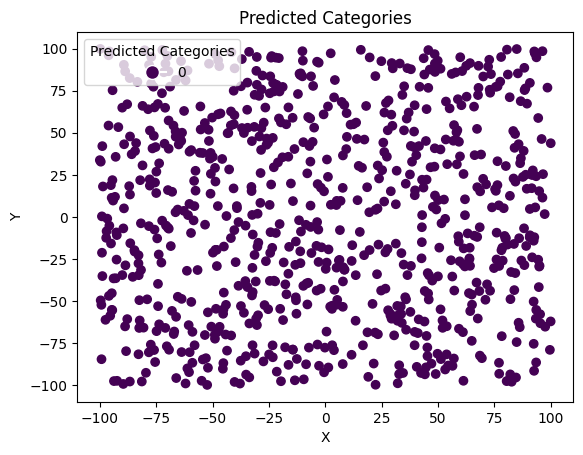

In [86]:
# 3.2 rings3 BASE
network = MLP([2, 10, 10, 10, 2], ["arctan", "arctan", "arctan", "softmax"])
train = pd.read_csv("../data/classification/xor3-balance-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("../data/classification/xor3-balance-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)

X_train = train[['x', 'y']].values
Y_train = train.drop(columns=['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns=['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)

avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 1230.9514729889595, f-measure: 0.355877616747182
Weights, epoch: 25, LOSS: 1026.8202848160017, f-measure: 0.355877616747182
Weights, epoch: 50, LOSS: 1013.5587818844178, f-measure: 0.4174073329746153
Weights, epoch: 75, LOSS: 980.6068016832803, f-measure: 0.44200605627573064
Weights, epoch: 100, LOSS: 959.4262996917857, f-measure: 0.4526287336126503
Weights, epoch: 125, LOSS: 935.2523044261619, f-measure: 0.4526287336126503
Weights, epoch: 150, LOSS: 917.4967500165582, f-measure: 0.45787138756303086
Weights, epoch: 175, LOSS: 872.282919699401, f-measure: 0.4623014252781145
Weights, epoch: 200, LOSS: 844.270717931935, f-measure: 0.4725446600346507
Weights, epoch: 225, LOSS: 813.3193895320152, f-measure: 0.4801152356038279
Weights, epoch: 250, LOSS: 774.8316711890985, f-measure: 0.4974205971609175
Weights, epoch: 275, LOSS: 737.4322611148062, f-measure: 0.5487927236889757
Weights, epoch: 300, LOSS: 682.6096002970011, f-measure: 0.5814732142857143
Weights, epoch: 

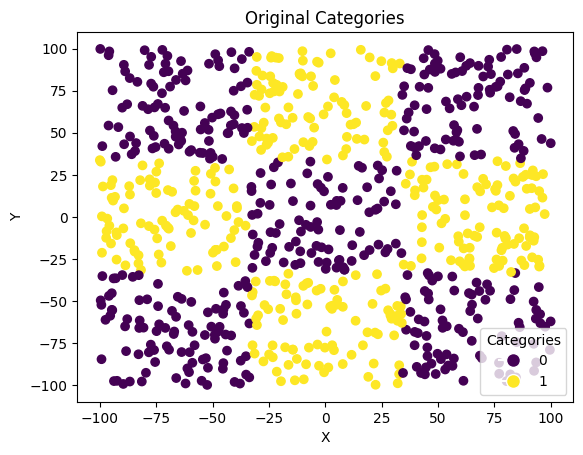

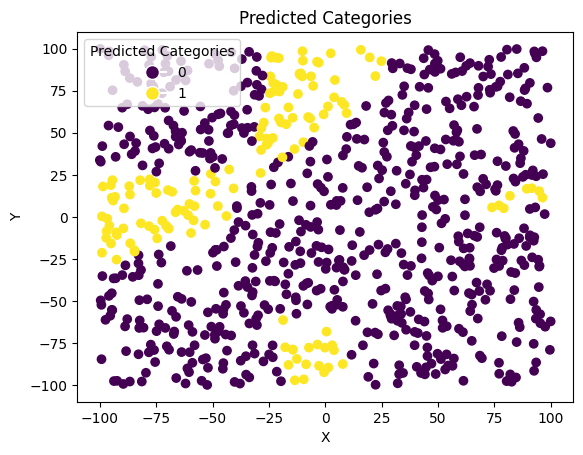

In [87]:
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

# 4.2 XOR L<sup>1

Weights, epoch: 0, LOSS: 1017.0781208153993, f-measure: 0.44801392625415415
Weights, epoch: 25, LOSS: 1039.4357498463767, f-measure: 0.355877616747182
Weights, epoch: 50, LOSS: 962.8604456890185, f-measure: 0.355877616747182
Weights, epoch: 75, LOSS: 914.4006600063185, f-measure: 0.37707281903388606
Weights, epoch: 100, LOSS: 884.4628813127256, f-measure: 0.4201898188093184
Weights, epoch: 125, LOSS: 877.8514694667408, f-measure: 0.4366245273194424
Weights, epoch: 150, LOSS: 796.8128596142084, f-measure: 0.4784009833968721
Weights, epoch: 175, LOSS: 764.5581568352168, f-measure: 0.49581108517631217
Weights, epoch: 200, LOSS: 619.2949460956632, f-measure: 0.5291953136455025
Weights, epoch: 225, LOSS: 642.7574184831117, f-measure: 0.519843827992539
Weights, epoch: 250, LOSS: 634.5785437777747, f-measure: 0.5695718609560592
Weights, epoch: 275, LOSS: 560.380904267829, f-measure: 0.6033318592287562
Weights, epoch: 300, LOSS: 535.3304389853799, f-measure: 0.6033318592287562
Weights, epoch: 

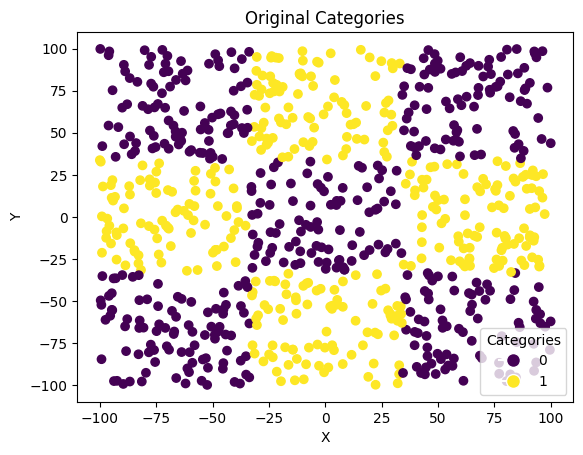

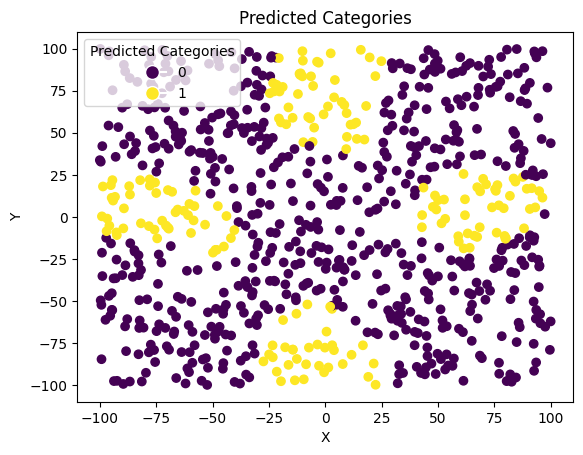

In [88]:
network = MLP([2, 10, 10, 10, 2], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 1)

# 4.3 XOR  L<sup>2

Weights, epoch: 0, LOSS: 822.0951746342846, f-measure: 0.40852706810153616
Weights, epoch: 25, LOSS: 1072.4908318428825, f-measure: 0.355877616747182
Weights, epoch: 50, LOSS: 990.0437921920569, f-measure: 0.355877616747182
Weights, epoch: 75, LOSS: 962.7187560272796, f-measure: 0.355877616747182
Weights, epoch: 100, LOSS: 949.3504058966057, f-measure: 0.355877616747182
Weights, epoch: 125, LOSS: 925.0635891335585, f-measure: 0.3917820259283674
Weights, epoch: 150, LOSS: 866.3103045554103, f-measure: 0.4682229784529971
Weights, epoch: 175, LOSS: 859.0113308521079, f-measure: 0.47078353669352396
Weights, epoch: 200, LOSS: 761.1806711847219, f-measure: 0.5291953136455025
Weights, epoch: 225, LOSS: 730.3009831317763, f-measure: 0.5519590905402811
Weights, epoch: 250, LOSS: 690.9285273326966, f-measure: 0.6155241617609906
Weights, epoch: 275, LOSS: 740.5911158804852, f-measure: 0.5824529337920142
Weights, epoch: 300, LOSS: 698.8696365207254, f-measure: 0.6195348396570508
Weights, epoch: 32

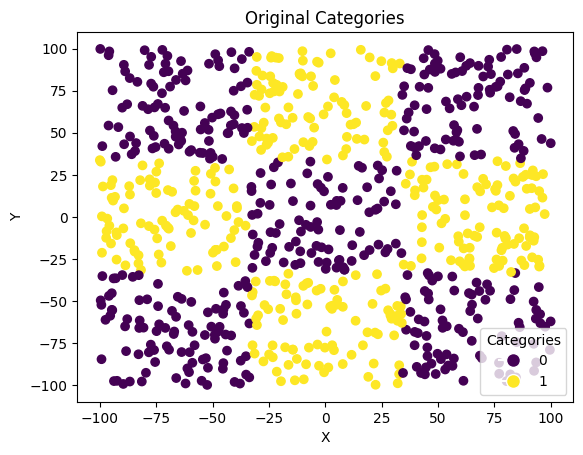

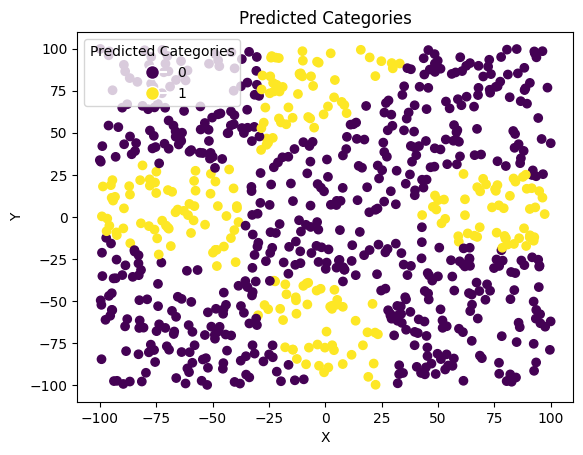

In [89]:
network = MLP([2, 10, 10, 10, 2], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 2)

# 4.4 XOR Early Stopping

Weights, epoch: 0, LOSS: 4590.13049023476, ema_LOSS: 4590.13049023476 f-measure: 0.355877616747182
Weights, epoch: 25, LOSS: 1063.9107175501044, ema_LOSS: 3901.978227184793 f-measure: 0.355877616747182
Weights, epoch: 50, LOSS: 842.1056126986552, ema_LOSS: 3239.1557648083167 f-measure: 0.463069230511091
Weights, epoch: 75, LOSS: 777.3169795220174, ema_LOSS: 2705.531818143519 f-measure: 0.5245376834105959
Weights, epoch: 100, LOSS: 761.6015430413613, ema_LOSS: 2278.4802938922976 f-measure: 0.5474744908591832
Weights, epoch: 125, LOSS: 751.3116718363929, ema_LOSS: 1941.1753066914941 f-measure: 0.580325014960636
Weights, epoch: 150, LOSS: 713.1799974244503, ema_LOSS: 1674.566796951269 f-measure: 0.6215303797564169
Weights, epoch: 175, LOSS: 731.1362140192598, ema_LOSS: 1465.3364071791314 f-measure: 0.6135089280959228
Weights, epoch: 200, LOSS: 727.8527971915572, ema_LOSS: 1301.1991383450843 f-measure: 0.6235194505500736
Weights, epoch: 225, LOSS: 712.7823597837329, ema_LOSS: 1171.41069749

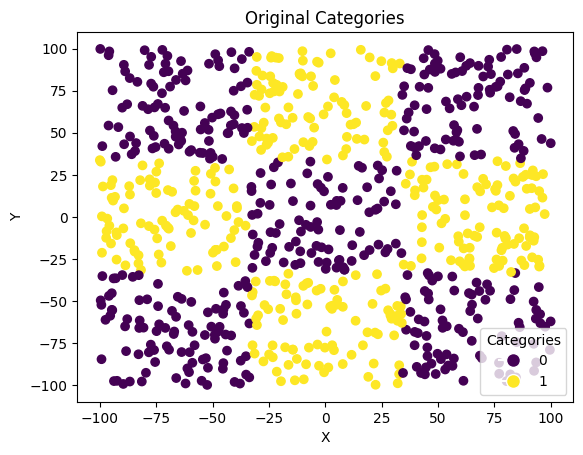

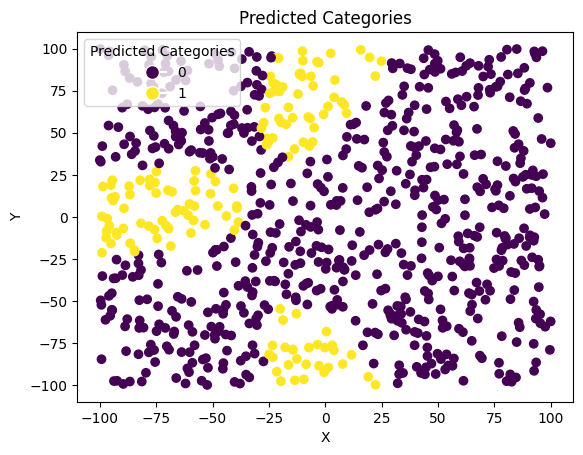

In [90]:
network = MLP([2, 10, 10, 10, 2], ["arctan", "arctan", "arctan", "softmax"])
learn_with_val_vis_cat_stop(data, network, 0.97, "CE", 0.02, 25, 0, 32, 500, 0)

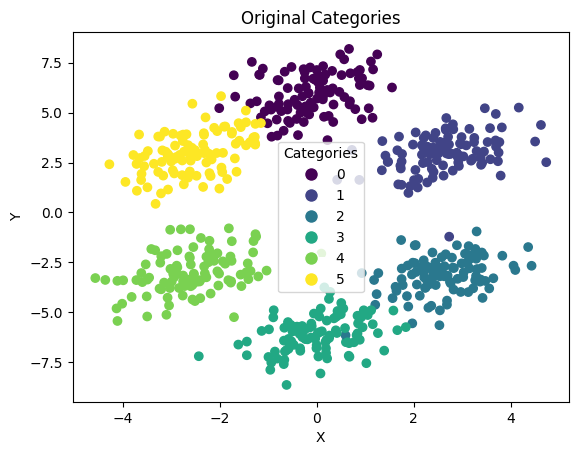

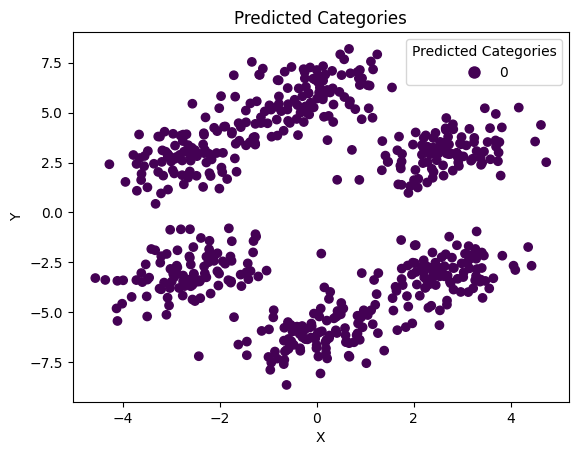

In [17]:
network = MLP([2, 10, 10, 10, 6], ["arctan", "arctan", "arctan", "softmax"])
train = pd.read_csv("../koh_data/hexagon.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("../koh_data/hexagon.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)

X_train = train[['x', 'y']].values
Y_train = train.drop(columns=['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns=['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)

avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 2912.997014310856, f-measure: 0.047619047619047616
Weights, epoch: 1, LOSS: 2912.997014310856, f-measure: 0.047619047619047616
Weights, epoch: 2, LOSS: 1442.9748872603993, f-measure: 0.17108415901122184
Weights, epoch: 3, LOSS: 773.5080643204269, f-measure: 0.25233471667078544
Weights, epoch: 4, LOSS: 572.8003834086401, f-measure: 0.5589739056082516
Weights, epoch: 5, LOSS: 493.96570861576595, f-measure: 0.7986784290785031
Weights, epoch: 6, LOSS: 440.86700291208774, f-measure: 0.8163159643705945
Weights, epoch: 7, LOSS: 398.99993374505004, f-measure: 0.8864802127760095
Weights, epoch: 8, LOSS: 362.4431923164325, f-measure: 0.9158060575519066
Weights, epoch: 9, LOSS: 331.7266308250106, f-measure: 0.9130801035369059
Weights, epoch: 10, LOSS: 303.9565865252977, f-measure: 0.9142854786026234
Weights, epoch: 11, LOSS: 280.47409653087345, f-measure: 0.9329353461598994
Weights, epoch: 12, LOSS: 259.88149067053723, f-measure: 0.9450074170272383
Weights, epoch: 13, LOS

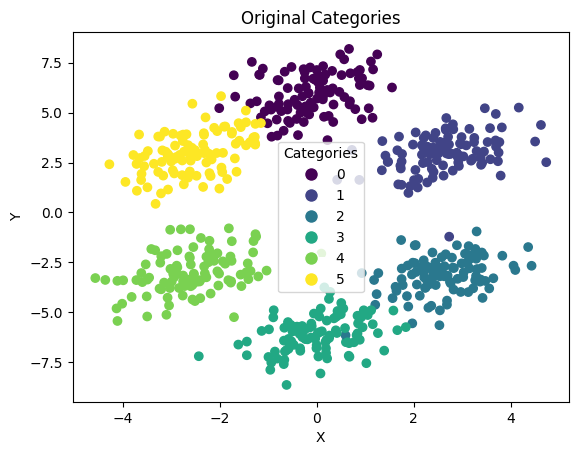

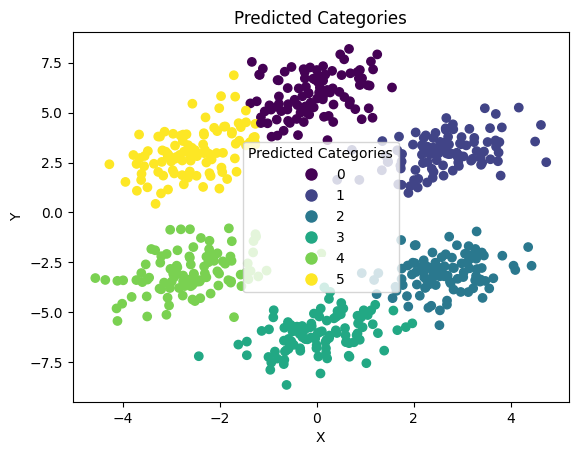

In [18]:
learn_with_val_vis_cat(data, network, 0.985, "CE", 0.02, 1, 0.9, 32, 500, 0)